# Sentiment Analysis, Part 2: NLP With Spark On Google Cloud
---------------

__[1. Introduction](#bullet1)__

__[2. Creating A GCP Hadoop Cluster ](#bullet2)__

__[3. Getting Data From An Atlas Cluter](#bullet3)__

__[4. Basic Models With Spark PiplineModels](#bullet4)__

__[5. Stemming With Custom Transformers](#bullet5)__

__[6. N-Grams And Parameter Tunning With Cross Validation](#bullet6)__

__[7. Conclusions](#bullet7)__


## Introduction  <a class="anchor" id="bullet1"></a>
--------------

In the <a href="http://michael-harmon.com/blog/SentimentAnalysisP1.html">first part</a> of this two part blog post I went over the basics of ETL with PySpark and MongoDB.  In this second part I will go over the actual modeling aspect of Sentiment Anlysis using <a href="https://spark.apache.org/docs/latest/ml-guide.html">SparkML</a> (aka MLlib it seems the name is changing).  Specifically, well be using <a href="https://spark.apache.org/docs/latest/ml-pipeline.html">MLPipelines</a> and <a href="https://en.wikipedia.org/wiki/Logistic_regression">Logistic Regression</a> to build a basic linear classifier for sentiment.  Then well introduce a custom <a href="https://spark.apache.org/docs/1.6.2/ml-guide.html#transformers">Transformer</a> class which uses the <a href="https://www.nltk.org/">NLTK</a> to performing stemming.  Lastly, well inroduce N-grams and go over <a href="https://spark.apache.org/docs/latest/ml-tuning.html">hyper-parameter tunning</a> with cross-validation. The point of this post *is not too build the best classifier on a huge dataset, but rather to show how to piece together advanced concepts into a ML Pipeline using PySpark.*

That said we will continue to use the 1.6 million <a href="https://www.kaggle.com/kazanova/sentiment140">tweets</a> from Kaggle which I loaded onto my <a href="https://www.mongodb.com/cloud/atlas">Atlas MongoDB</a> cluster with the Spark job that was discussed in the last post.  While 1.6 million tweets doesn't necessitate a distributed environment, using PySpark on this datset was a little too much my whimpy 2013 Macbook Air and I needed to use a more powerful machine.  Luckily <a href="https://cloud.google.com/">Google Cloud Platform</a> (GCP) gives everyone free credits to start using their platform and I was able to use Spark on a <a href="https://hadoop.apache.org/">Hadoop</a> cluster using <a href="https://cloud.google.com/dataproc/">dataproc</a> and <a href="https://cloud.google.com/datalab/">datalab</a>. 


Let's get started!


## Creating A GCP Hadoop Cluster  <a class="anchor" id="bullet2"></a>
---------
I have been using Hadoop and Spark for quite some time now, but have never spun up my own cluster and gained a new found respect for Hadoop admins.  Google does make the process easy, but I had to ask a friend for help.  Between getting the correct version of Python as well as the correct version of NLTK on both the driver and worker nodes, the correct MongoDB connector for PySpark 2.3.2 and the time it takes to spin up and shut down a cluster I was very much over configuting clusters on my own.  I want to say that made me a better person or atleast data scientist, but I'm not so sure. :)

On the GCP free trial I could only pass use two worker nodes and the command to create a Hadoop clsuter with two nodes is shown below:

![](images/CreateCluster.png)

You can see the connector for MongoDB as well as the version of Python in the strings above.  The bash scripts reference in my Google storage bucket for this project can be seen in my repo <a href="https://github.com/mdh266/TwitterSentimentAnalysis/tree/master/GCP">here</a>.  After the cluster is created we  can ssh onto the master node by going to the console and click on "*Compute Enginee* tab.  You will see a page like the one below:

![](images/MasterNode.png)

We can ssh on the master node using the ssh tap to the right of the instance name **mikescluster-m**.  The "-m" signifies it is the master node while the other instances have "-w" signifiying they are worker ndoes. After connecting to the mater node you can see all the <a href="https://data-flair.training/blogs/top-hadoop-hdfs-commands-tutorial/">Hadoop commands</a> available:


![](images/HDFS.png)

However, we won't work on our Hadoop cluster through command line and connect to through Jupyter notebooks using Google <a href="https://cloud.google.com/datalab/">datalab</a>. This involves creating an ssh-tunnel and proxy for Chrome, both of which I had no idea how to do, but luckily had friend walk me through it.  The bash scripts I used to do these last two steps are located in my repo <a href="https://github.com/mdh266/TwitterSentimentAnalysis/tree/master/GCP">here</a>. After those steps were completed we can just go to the address

    http://mikescluster-m:8080
 
To see the Jupyter notebooks.  Note that that notebooks are running of the master node on port 8080 and that <a href="https://hadoop.apache.org/docs/current/hadoop-yarn/hadoop-yarn-site/YARN.html">YARN</a> can be see from the same address but with port 8088.  Now that we have our Hadoop cluster up and running on GCP we need to access our data.

## Getting The Dataset From An Atlas Cluster <a class="anchor" id="bullet3"></a>
---------

As I mentioned in the introduction I loaded the cleaned Twitter dataset into my Atlast MongoDB cluster.  The ETL job was discussed in the previous <a href="http://michael-harmon.com/blog/SentimentAnalysisP1.html">post</a> and in this post I will just show how to connect PySpark to the MongoDB database.  The only thing I will note is that to keep my collection with the limits of the free tier of Atlas I had to store the data as strings and not tokenized, so we'll do that again here.

First step, however, is that we need to create a connection url string containing the cluster address, user info, as well as database and collection name in the dictionary below:

In [1]:
mongo_conn = {"address"    : "harmoncluster-xsarp.mongodb.net/", 
              "db_name"    : "db_twitter",
              "collection" : "tweets",
              "user"       : "",
              "password"   : ""}

url   = "mongodb+srv://{user}:{password}@{address}{db_name}.{collection}".format(**mongo_conn)

Then we read documents the collection using the <code>spark.read</code> command passing in that we are using MongoDB as the format and the url as our option:

In [8]:
df = spark.read\
          .format("com.mongodb.spark.sql.DefaultSource")\
          .option("uri",url)\
          .load()

At this point, while the data hasn't quite been pulled from the source yet we would seen an error if the was a mistake in our connection string.  While we have not all the document from the Atlas cluster to our Hadoop cluster we have pulled metadata on the collection and can infer schema using the command below:

In [9]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- sentiment: integer (nullable = true)
 |-- tweet_clean: string (nullable = true)



You can see that each document has an <code>id</code>, <code>sentiment</code> and the cleaneed tweet, <code>tweet_clean</code>.  We re tokenize the clean tweets and rename the sentiment column of our dataframe:

In [10]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol  = "tweet_clean",
                      outputCol = "tokens")

df2 = tokenizer.transform(df)\
               .select("tokens","sentiment")\
               .withColumnRenamed("sentiment", "label")

Then we split into training and testing sets with a seed (1234) below,

In [11]:
train, test = df2.randomSplit([0.80, 0.20], 1234)

Now we can look at the number of training tweets with positive and negative sentiment below. Note, since our well be using this dataframe multiple times in the machine learning pipelines we cache it for better performance.

In [12]:
train.cache()

DataFrame[tokens: array<string>, label: int]

In [13]:
train.groupby("label")\
     .count()\
     .show()

+-----+------+
|label| count|
+-----+------+
|    1|638006|
|    0|638503|
+-----+------+



We can see that the classes are well balanced with nearly half a million positive and negative teets.  We do the same for the test set:

In [14]:
test.cache()

DataFrame[tokens: array<string>, label: int]

In [15]:
test.groupby("label")\
    .count()\
    .show()

+-----+------+
|label| count|
+-----+------+
|    1|159530|
|    0|159963|
+-----+------+



Again, the classes in the test sets are well balanced.  This is great because we don't have to worry about dealing with imbalanced classes and accuracy and ROC's area under the curve (AUC) are good metrics to see how well our models are performing.

Normally, I would do some exploratory data analysis on the dataset, but I given that I'm paying for time on a cluster I would rather stick to showing how to create Spark ML Pipelines in this post.

## Basic Pipeline Classifiers <a class="anchor" id="bullet4"></a>
------------
In this section well go over using a basic logistic regression model using Spark <a href="https://spark.apache.org/docs/latest/ml-pipeline.html">MLPipelines</a> which are similar to <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">Scikit-learn Pipelines</a>.  One thing to note is that I have already tokenized my tweets before writting them to the MongoDB datbase so there is no need to use the <a href="https://spark.apache.org/docs/2.1.0/ml-features.html#tokenizer">Tokenizer</a> class in any of our pipelines.


We import the basic modules below:

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Next we instantiate our classification evalutor class and pass the label of the output column from pipeline model:

In [17]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# get the name of the metric used
evaluator.getMetricName()

'areaUnderROC'

We'll be using the <a href="https://en.wikipedia.org/wiki/Bag-of-words_model">**bag of words model**</a> to build features from tweets to be feed into the model.  *In the bag-of-words model, a document (in this case tweet) is represented as "bag" or list of its words, disregarding grammar and ordering, but keeping the multiplicity of the words.*  A two document example is:

- **D1:**  Hi, I am Mike and I like Boston.

- **D2:**  Boston is a city and people in Boston like the Red Sox.

From these two documents, a list, or 'bag-of-words' is constructed

    bag = ['Hi', 'I', 'am', 'Mike', 'and', 'like', 'Boston', 'is', 
           'a', 'city, 'and', 'people', 'in', 'the', 'red', 'sox]


Notice how in our bag-of-words we have dropped repetitions of the words 'I', 'is' and 'Mike', we will show how multiplicity of words enters into our model next. 

The bag-of-words model is mainly used as a tool of feature generation. After transforming the text into a "bag of words", we can calculate various measures to characterize the document.  In order to do so we have to generate a vector for each document that represents the number of times each entry in the bag of words appears in the text. The order of entries in the vector corresponds to the order of the entries in the bag-of-words list.  For example, document D1 would have a vector,

    [1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0 ,0, 0, 0, 0, 0]
    
while the second document, D2, would have the vector,

    [0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]

Each entry of the lists refers to frequency or count of the corresponding entry in the bag-of-words list.  When we have a stacked collection of (row) vectors, or matrix, where each row corresponds to a document (vector), and each column corresponds to a word in the bag-of-words list, then this will be known as our **term-frequency ($\text{tf}$) [document matrix](https://en.wikipedia.org/wiki/Document-term_matrix)**. The general formula for an entry in the $\text{tf}$ matrix is,

$$\text{tf}(d,t) \,  = \, f_{t,d}$$
    
where $f_{t,d}$ is the number of times the term $t$ occurs in document $d \in \mathcal{D}$, where $\mathcal{D}$ is our text corpus.  We can create a term-frequency matrix using Spark's <a href="https://spark.apache.org/docs/latest/ml-features.html#countvectorizer">CountVectorizer</a> class.  

Most often term-frequency alone is not a good measure of the importance of a word/term to a document's topic.  Very common words like "the", "a", "to" are almost always the terms with the highest frequency in the text. Thus, having a high raw count of the number of times a term appears in a document does not necessarily mean that the corresponding word is more important. Furtermore, longer documents could have high frequency of terms that do not correlate with the document topic, but instead occur with high numbers solely due to the length of the document.

To circumvent the limination of term-frequency, we often normalize it by the **inverse document frequency (idf)**.  This results in the **term frequency-inverse document frequency (tf-idf)** matrix.  The *inverse document frequency is a measure of how much information the word provides, that is, whether the term is common or rare across all documents in the corpus*.  We can give a formal defintion of the inverse-document-frequency by letting $\mathcal{D}$ be the corpus or the set of all documents and $N$ is the number of documents in the corpus and $N_{t,D}$ be the number of documents that contain the term $t$ then, 

$$idf(t,\mathcal{D}) \, = \,  \log\left(\frac{N_{\mathcal{D}}}{1 + N_{t,\mathcal{D}}}\right) \, = \, -  \log\left(\frac{1 + N_{t,\mathcal{D}}}{N_{\mathcal{D}}}\right) $$

The reason for the presence of the $1$ is for smoothing.  Without it, if the term/word did not appear in any training documents, then its inverse-document-frequency would be $idf(t,\mathcal{D}) = \infty$.  However, with the presense of the $1$ it will now have $idf(t,\mathcal{D}) = 0$.


Now we can formally defined the term frequnecy-inverse document frequency as a normalized version of term-frequency,


$$\text{tf-idf}(t,d) \, = \, tf(t,d) \cdot idf(t,\mathcal{D}) $$

Like the term-frequency, the term frequency-inverse document frequency is a sparse matrix, where again, each row is a document in our training corpus ($\mathcal{D}$) and each column corresponds to a term/word in the bag-of-words list.  The $\text{tf-idf}$ matrix can be constructed using the sklearn <a href="https://spark.apache.org/docs/latest/ml-features.html#tf-idf">IDF</a> class.


The basic pipeline we use includes:

    - tokenization (done previously)
    - creating term frequency
    - creating term frequency inverse document frequency 
    - fitting a logistic regression model to the BOW created from the previou steps
    
This is all done in the short few lines below:

In [18]:
# create term frequencies from tokens
tf1 = CountVectorizer(inputCol="tokens", outputCol="rawFeatures")

# create tf-idfs from the term frequneies
idf = IDF(inputCol="rawFeatures", outputCol="features")

# create basic logistic regression model
lr = LogisticRegression(maxIter=20)

# create basic pipeline
basic_pipeline = Pipeline(stages=[tf1, idf, lr])

Now we can train perform feature extraction (tf-idf) and train the model all with the following command:

In [19]:
model1         = basic_pipeline.fit(train)

Once we have trained the pipeline model we can predict it's perfromance on the test set using the <code>transform</code> method and using the <code>evaluate</code> method of the evaluator object.

In [20]:
# predict on test set
predictions1   = model1.transform(test)

# get the performance on the test set
score1         = evaluator.evaluate(predictions1)

print("AUC SCORE: {}".format(score1))

AUC SCORE: 0.9105776502556013


91% of the area under the ROC curve is very good, but let's see if we can make easy any improvements

### Removing Stop Words

One thing people usually do is to remove stop words, i.e. common words that do not add any additional information into the model.  Examples of stop words are: 'a', 'the', 'and', etc.  We remove stop words from in our  tokens by using the <a href="https://spark.apache.org/docs/2.1.0/ml-features.html#stopwordsremover">StopWordsRemover</a> class.

In [21]:
from pyspark.ml.feature import StopWordsRemover

We can instantiate a new StopWordsRemover object, changing the input column name for the CountVectorizer to be the output column name of the StopWordRemover and create our new pipeline.

In [22]:
sw  = StopWordsRemover(inputCol="tokens", outputCol="filtered")
tf2 = CountVectorizer(inputCol="filtered", outputCol="rawFeatures")

stopwords_pipleline = Pipeline(stages=[sw, tf2, idf, lr])

Then we train model and evaluate its performance on the test set:

In [23]:
model2         = stopwords_pipleline.fit(train)
predictions2   = model2.transform(test)
score2         = evaluator.evaluate(predictions2)

print("AUC SCORE: {}".format(score2))

AUC SCORE: 0.9013580561679387


We can see in this case that AUC score went down slightly with removing stop words.  This is probably because each of the tweets was rather small (number of characters wise).  Our model was probably overfitting to stop words and giving them informational value it shouldn't.  In any case, in this post were not too concerned about the performance as showing how all the pieces of machine leanring with Spark can be tied together with pipelines.

## Stemming With Customer Tranformers <a class="anchor" id="bullet5"></a>
------------

We will use the Natural Language Tool Kit (<a href="https://www.nltk.org/">NLTK</a> ) with the Porter Stemmer for stemming.  Stemming is the process of reducing words down to their root,  for example from Wikipedia :

...the Porter algorithm reduces, argue, argued, argues, arguing, and argus to the stem argu 

Stemming is used as an approximate method for grouping words with a similar basic meaning together.  For NLP and the bag of words model this reduces the dimension of our featur space since variations in words that would normally be counted seperately are reduced to one word that is counted collectively.


For some reason gcloud kept installing the wrong version of NLTK and inorder to get the correct version on the driver and workers I had to install within the notebook

In [24]:
%sh
pip install -U nltk==3.4

Requirement already up-to-date: nltk==3.4 in /usr/local/envs/py3env/lib/python3.5/site-packages (3.4)


We can now import the NLTK to and check its version is correct

In [25]:
import nltk
print(nltk.__version__)
from nltk.stem.porter import PorterStemmer

3.4


We can show an example how to stemming works on a sentence by first instantiating the PorterStemmer object and tokenizing a sentence:

In [18]:
stemmer = PorterStemmer()

tokens         = "my feelings having studied all day".split(" ")
print("raw tokens: {}".format(tokens))

raw_tokens: ['my', 'feelings', 'having', 'studied', 'all', 'day']


we can then apply the stemmer's stem function to each token in the array:

In [19]:
tokens_stemmed = [stemmer.stem(token) for token in tokens]
print("clean tokens: {}".format(tokens))

clean tokens: ['my', 'feelings', 'having', 'studied', 'all', 'day']


In order to user the Porter stemmer within a PySpark ML Pipeline we must create as a <a href="https://spark.apache.org/docs/latest/ml-pipeline.html#transformers">Transformer</a>.  Transformer allow us to apply non-Spark functions and transformations as stages within our MLPipeline.  We create a customer PortersStemming class which extends PySparks Transformer class, HasInputCol class and HasOutputCol class, see <a href="https://github.com/apache/spark/blob/master/python/pyspark/ml/param/shared.py">here</a> for class definitions.

In [11]:
from pyspark import keyword_only
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param


class PorterStemming(Transformer, HasInputCol, HasOutputCol):
    """
    This comes from https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    Adapted to work with the Porter Stemmer from NLTK.
    """
    
    @keyword_only
    def __init__(self, 
                 inputCol  : str = None, 
                 outputCol : str = None, 
                 min_size  : int = None):
      """
      Constructor takes in the input column name, output column name,
      plus the minimum legnth of a token (min_size)/
      """
      # call Transformer classes constructor since were extending it.
      super(Transformer, self).__init__()

      #set Parameter objects minimum token size
      self.min_size = Param(self, "min_size", "")
      self._setDefault(min_size=0)

      # set the input keywork arguments
      kwargs = self._input_kwargs
      self.setParams(**kwargs)

      # initialize Stemmer object
      self.stemmer  = PorterStemmer()

        
    @keyword_only
    def setParams(self, 
                  inputCol  : str = None, 
                  outputCol : str = None, 
                  min_size  : int = None
      ) -> None:
      """
      Function to set the keyword arguemnts
      """
      kwargs = self._input_kwargs
      return self._set(**kwargs)
    

    def _stem_func(self, words  : list) -> list:
      """
      Stemmer function call.
      """
      # We need a way to get min_size and cant access it 
      # with self.min_size
      min_size       = self.getMinSize()
      # stemm that actual tokens
      stemmed_words  = map(self.stemmer.stem, words)
      # now create the new list of tokens by filtering out those
      # that are not of legnth > min_size
      filtered_words = filter(lambda x: len(x) > min_size, stemmed_words)

      return list(filtered_words)
    
    def _transform(self, df: DataFrame) -> DataFrame:
      """
      Transform function is the function that is called in the 
      """
      
      out_col       = self.getOutputCol()
      in_col        = self.getInputCol()

      # create the stemming function udf by wrapping the stemmer 
      # method function
      stem_func_udf = F.udf(self._stem_func, ArrayType(StringType()))
      df2           = df.withColumn(out_col, stem_func_udf(df[in_col]))
   
      return df2
  
  
    def setMinSize(self,value):
      self._paramMap[self.min_size] = value
      return self

    def getMinSize(self) -> int:
      return self.getOrDefault(self.min_size)

        

The keys of creating this derived class are to 

1. Create a <code>Param</code> in the constructor which will hold our user defined parameter names, values and default values.

2. 

3. A <code>_transform</code> which applies a customer transformation to the <code>inputCol</code> to return a new column with name <code>outputCol</code>


In [71]:
# create stemming object 
stem = PorterStemming(inputCol="filtered", outputCol="stemmed")

# create new CountVectorizer object
tf3 = CountVectorizer(inputCol="stemmed", outputCol="rawFeatures")

# create new pipline
stemming_pipeline  = Pipeline(stages= [sw, stem, tf3, idf, lr])

# fit and get predictions
model3         = stemming_pipeline.fit(train)
predictions3   = model3.transform(test)
score3         = evaluator.evaluate(predictions3)

In [72]:
print("AUC SCORE: {}".format(score3))

AUC SCORE: 0.9050744113870046


Not too much of an improvement.

In [22]:
stop_and_step_pipeline = Pipeline(stages= [sw, stem]).fit(train)

In [23]:
train_stem = stop_and_step_pipeline.transform(train)
test_stem  = stop_and_step_pipeline.transform(test)

# cache them
train_stem.cache()
test_stem.cache()

## N-Grams And Parameter Tunning With Cross Validation <a class="anchor" id="bullet6"></a>
--------------------

In [52]:
from pyspark.ml.feature import NGram

bigram = NGram(inputCol="stemmed",
              outputCol="bigrams",
              n=2)

tf4   = CountVectorizer(inputCol="bigrams", outputCol="rawFeatures")

bigram_pipeline  = Pipeline(stages= [sw, bigram, tf4, idf, lr])

model4           = bigram_pipeline.fit(train_stem)
predictions4     = model4.transform(test_stem)

score4           = evaluator.evaluate(predictions4)

In [53]:
print("AUC SCORE: {}".format(score4))

AUC SCORE: 0.9258992079438101


blah blah blah

In [55]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
                        .addGrid(tf4.minDF, [1.0, 3.0, 5.0]) \
                        .build()
     
crossval = CrossValidator(estimator          = bigram_pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator          = BinaryClassificationEvaluator(),
                          numFolds           = 3)

model    = crossval.fit(train_stem)

Make predictions on test set

In [56]:

predictions   = model.transform(test_stem)

score         = evaluator.evaluate(predictions)

In [57]:
print("AUC SCORE: {}".format(score))

AUC SCORE: 0.9236064128788266


In [59]:
bestModel = model.bestModel

<code>TrainValidationSplit</code> only evaluates each parameter choice once instead of multiple times over each of the $K$ fold in <code>CrossValidator</code>.  Therefore this estimator is not as expensive as cross validation,
but can produce less reliable results when dataset isn't large enough.  See the <a href="https://spark.apache.org/docs/latest/ml-tuning.html#train-validation-split">documenation</a> for more infromation.

In [60]:
bestModel.stages

[StopWordsRemover_423599bec5871e3ffed4,
 NGram_4502beb9404a4311b4d3,
 CountVectorizer_4a988db9b1e4fcfac4fe,
 IDF_4240bcd585ec2afbe47c,
 LogisticRegression_4232bcf280c352f5096b]

In [62]:
bestModel.stages[2].explainParam('minDF')

'minDF: Specifies the minimum number of different documents a term must appear in to be included in the vocabulary. If this is an integer >= 1, this specifies the number of documents the term must appear in; if this is a double in [0,1), then this specifies the fraction of documents. (default: 1.0, current: 5.0)'

In [63]:
summary = bestModel.stages[-1].summary

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


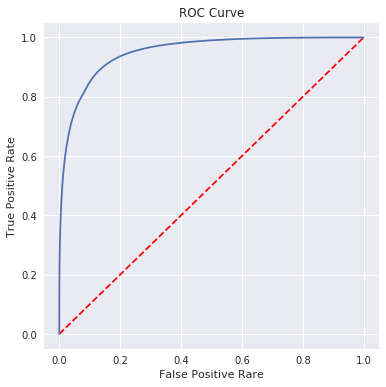

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(summary.roc.select('FPR').collect(),
         summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rare')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.show()

In [65]:
bestModel.save("model")

In [66]:
import os

In [67]:
os.system("hdfs dfs -get model")

0

In [73]:
print("Accuracy: {}".format(summary.accuracy))

Accuracy: 0.8788837368165834


## Conclusions <a class="anchor" id="bullet7"></a>
----------------------